# Experiment to explore the performance of the SB-VAE behaviour over the architecture found in previous experiments

In [16]:
from dataclasses import dataclass, asdict
from typing import List, Tuple
import tensorflow as tf
import numpy as np
from utils.batches.application.batch_selector import BatchSelector
from utils.epsilons.application.epsilon_generator_selector import EpsilonGeneratorSelector
from utils.external.fid.fid import frechet_inception_distance
from utils.losses.images.application.image_loss_function_selector import ImageLossFunctionSelector
from project.infrastructure.images.SBVAE import SBVAE


@dataclass(frozen=True)
class Dataset:
    dataset: List
    image_height: int
    image_width: int
    n_channels: int

sb_base = {
    "encoder_architecture": [175, 150, 125, 100, 75, 50, 25],
    "decoder_architecture": [25, 50, 75, 100, 125, 150, 175],
    "encoder_activations": [tf.nn.relu,tf.nn.relu,tf.nn.relu,tf.nn.relu,tf.nn.relu,tf.nn.relu,tf.nn.relu],
    "decoder_activations": [tf.nn.relu,tf.nn.relu,tf.nn.relu,tf.nn.relu,tf.nn.relu,tf.nn.relu,tf.nn.relu],
    "decoder_output_activation": tf.nn.sigmoid,
    "learning_rate": 0.0001,
    "n_distributions": 5,
    "loss": ImageLossFunctionSelector.ImageLosses.STICKBREAKING_MSE.value
}

In [41]:
# Common functions

import matplotlib.pyplot as plt


def examples(model, factor = 1.0, cmap = 'gray'):
    gamma_samples = tf.random.gamma((9,5), 1., 5.)
    proportions = gamma_samples / tf.reduce_sum(gamma_samples)
    cm_props = cumulative_proportions = tf.math.cumprod(1 - proportions)

    generated = model.generate_with_multiple_samples(
        cm_props * tf.random.uniform(shape=(9,5), minval=0, maxval=1)
        * factor
    )

    plt.figure()
    fig, axes = plt.subplots(3, 3)
    for i, ax in enumerate(axes.flat):
        image = generated[i]

        ax.imshow(image, cmap=cmap)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def line_plot(y, y_label, x_label, title):
    plt.figure()

    plt.title(title)
    plt.plot(range(1,len(y)+1), y, color='red')

    # Set labels for x and y axes
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Display the plot
    plt.show()

def perform_analysis(model_name, configuration, dataset, dataset_activations, get_activations_method ,max_iter = 500, times = 10) -> Tuple[SBVAE, List, List, List]:
    cvae = SBVAE(
        **{**configuration, **asdict(dataset)},
        max_iter=max_iter,
    )

    fids = []
    losses = []
    summaries = []
    for t in range(1, times+1):
        loss, summary = cvae.fit_dataset(
            return_loss=True,
            epsilon_generator=EpsilonGeneratorSelector.EpsilonGenerators.SAME_EPSILON.value,
            batch_size=64,
            batch_type=BatchSelector.Batches.CYCLIC_BATCH.value,
            generate_samples=False,
        )

        # we select random images from the dataset
        generated_images = cvae.generate_with_random_sample(dataset_activations.shape[0])
        generated_activations = get_activations_method(generated_images)

        try:
            frechet_inception_distance_metric = frechet_inception_distance(
                dataset_activations,
                generated_activations
            )
        except Exception:
            frechet_inception_distance_metric = np.inf

        fids.append(frechet_inception_distance_metric)
        losses=losses+loss
        summaries=summaries+summary

    print(f"LOSS RESULTS OF {model_name}:\n")
    line_plot(losses, 'Loss values', 'Iterations', 'Loss Value Over Iterations')
    line_plot(list(map(lambda x: x["sb_dkl"],summaries)), 'sb-KL values', 'Iterations', 'Stick-Breaking Kullback-Leibler Over Iterations')
    line_plot(list(map(lambda x: x["mse"],summaries)), 'MSE values', 'Iterations', 'MSE Over Iterations')
    print("")
    print("FIDS:\n")
    line_plot(fids, 'FID', 'Trainings', 'FID Over Trainings')

    return cvae, fids, losses, summaries

def show_performance(fids,losses, summaries, model, cmap="gray"):
    fid = fids[-1]
    loss = losses[-1]
    sb_dkl = summaries[-1]["sb_dkl"]
    mse = summaries[-1]["mse"]

    print("THE MODEL FID IS:")
    print(f"=====================>{fid}\n")

    print("THE MODEL LOSS IS:")
    print(f"=====================>{loss}\n")

    print("THE MODEL KULLBACK-LEIBLER LOSS IS:")
    print(f"=====================>{sb_dkl}\n")

    print("THE MODEL MSE LOSS IS:")
    print(f"=====================>{mse}\n")

    print("SAMPLING EXAMPLE")
    examples(model, cmap=cmap)
    print("SAMPLING EXAMPLE: X100")
    examples(model, factor=100, cmap=cmap)

## MNIST dataset

### Preparations

In [4]:
# We prepare the custom inception model for measuring the FID and the dataset

(TRAIN_IMAGES, TRAIN_LABELS), (TEST_IMAGES, TEST_LABELS) = tf.keras.datasets.mnist.load_data()
mnist = Dataset(
    dataset=TRAIN_IMAGES,
    image_width=28,
    image_height=28,
    n_channels=1,
)

def create_inception_mnist_model():
    tmp_model = tf.keras.Sequential()

    # First Convolutional block
    tmp_model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    tmp_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional block
    tmp_model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
    tmp_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Flatten the feature maps
    tmp_model.add(tf.keras.layers.Flatten())

    # Fully connected layers
    tmp_model.add(tf.keras.layers.Dense(64, activation='relu'))
    tmp_model.add(tf.keras.layers.Dropout(0.5))
    tmp_model.add(tf.keras.layers.Dense(10, activation='softmax'))

    return tmp_model

tf.keras.backend.clear_session()

# Preprocess MNIST dataset
x_train = TRAIN_IMAGES.reshape((-1, 28,28,1))
x_test = TEST_IMAGES.reshape((-1, 28,28,1))
x_train = tf.cast(x_train, dtype=tf.float32) / 255.0
x_test = tf.cast(x_test, dtype=tf.float32) / 255.0
y_train = tf.keras.utils.to_categorical(TRAIN_LABELS, num_classes=10)
y_test = tf.keras.utils.to_categorical(TEST_LABELS, num_classes=10)

model = create_inception_mnist_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

INTERCEPTED_LAYER_INDEX = 5

intercepted_model_mnist = tf.keras.Model(inputs=model.input, outputs=model.layers[INTERCEPTED_LAYER_INDEX].output)

def get_activations_mnist(x : tf.Tensor) -> tf.Tensor:
    return tf.convert_to_tensor(intercepted_model_mnist.predict(x))

Epoch 1/10
1875/1875 [==============================] - 22s 11ms/step - loss: 0.3146 - accuracy: 0.9043 - val_loss: 0.0618 - val_accuracy: 0.9810
Epoch 2/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.1368 - accuracy: 0.9590 - val_loss: 0.0477 - val_accuracy: 0.9837
Epoch 3/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.1037 - accuracy: 0.9694 - val_loss: 0.0408 - val_accuracy: 0.9871
Epoch 4/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0867 - accuracy: 0.9747 - val_loss: 0.0348 - val_accuracy: 0.9899
Epoch 5/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0743 - accuracy: 0.9780 - val_loss: 0.0369 - val_accuracy: 0.9883
Epoch 6/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0653 - accuracy: 0.9810 - val_loss: 0.0265 - val_accuracy: 0.9917
Epoch 7/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0585 - accuracy: 0.9823 - val_loss: 0.0294 -

In [12]:
# We prepare the activations of the dataset

mnist_activations = get_activations_mnist(x_test)

313/313 [==============================] - 2s 5ms/step


### Model

313/313 [==============================] - 2s 5ms/step
LOSS RESULTS OF SB-VAE:



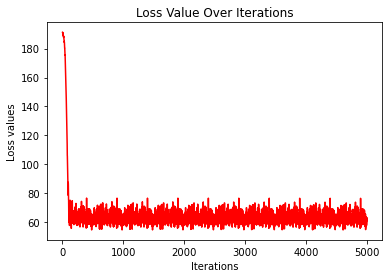

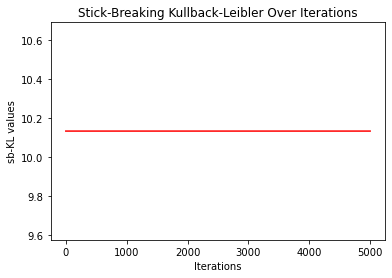

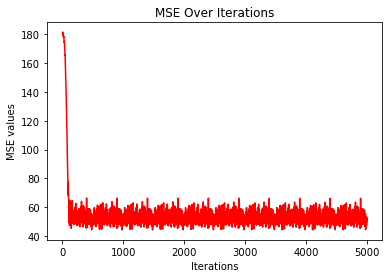


FIDS:



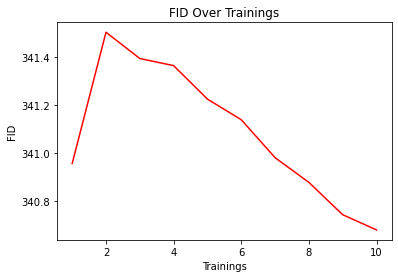

In [27]:
_SBVAE_mnist, fids_sbvae_mnist, losses_sbvae_mnist, summaries_sbvae_mnist =(
    perform_analysis(
        "SB-VAE",
        sb_base,
        mnist,
        mnist_activations,
        get_activations_mnist
    )
)

THE MODEL FID IS:
=====================>340.6805918003397

THE MODEL LOSS IS:
=====================>62.90521240234375

THE MODEL KULLBACK-LEIBLER LOSS IS:
=====================>10.134631156921387

THE MODEL MSE LOSS IS:
=====================>52.77058029174805

SAMPLING EXAMPLE


<Figure size 432x288 with 0 Axes>

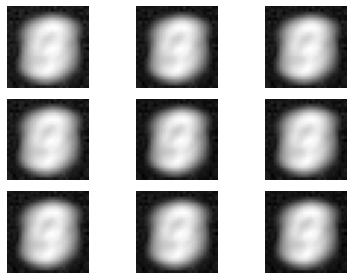

SAMPLING EXAMPLE: X100


<Figure size 432x288 with 0 Axes>

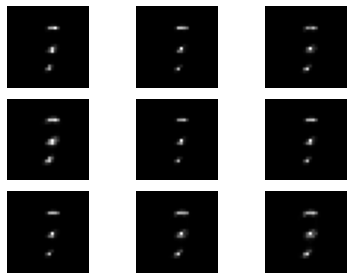

In [42]:
show_performance(fids_sbvae_mnist, losses_sbvae_mnist, summaries_sbvae_mnist, _SBVAE_mnist)

## FASHION-MNIST dataset

### Preparations

In [44]:
# We prepare the custom inception model for measuring the FID and the dataset

(TRAIN_IMAGES, TRAIN_LABELS), (TEST_IMAGES, TEST_LABELS) = tf.keras.datasets.fashion_mnist.load_data()
fashionmnist = Dataset(
    dataset=TRAIN_IMAGES,
    image_width=28,
    image_height=28,
    n_channels=1,
)

def create_inception_fashionmnist_model():
    tmp_model = tf.keras.Sequential()

    # First Convolutional block
    tmp_model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    tmp_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional block
    tmp_model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
    tmp_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Flatten the feature maps
    tmp_model.add(tf.keras.layers.Flatten())

    # Fully connected layers
    tmp_model.add(tf.keras.layers.Dense(64, activation='relu'))
    tmp_model.add(tf.keras.layers.Dropout(0.5))
    tmp_model.add(tf.keras.layers.Dense(10, activation='softmax'))

    return tmp_model

tf.keras.backend.clear_session()

# Preprocess dataset
x_train = TRAIN_IMAGES.reshape((-1, 28,28,1))
x_test = TEST_IMAGES.reshape((-1, 28,28,1))
x_train = tf.cast(x_train, dtype=tf.float32) / 255.0
x_test = tf.cast(x_test, dtype=tf.float32) / 255.0
y_train = tf.keras.utils.to_categorical(TRAIN_LABELS, num_classes=10)
y_test = tf.keras.utils.to_categorical(TEST_LABELS, num_classes=10)

model = create_inception_fashionmnist_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

INTERCEPTED_LAYER_INDEX = 5

intercepted_model_fashionmnist = tf.keras.Model(inputs=model.input, outputs=model.layers[INTERCEPTED_LAYER_INDEX].output)

def get_activations_fashionmnist(x : tf.Tensor) -> tf.Tensor:
    return tf.convert_to_tensor(intercepted_model_fashionmnist.predict(x))

Epoch 1/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.6956 - accuracy: 0.7479 - val_loss: 0.4370 - val_accuracy: 0.8371
Epoch 2/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.4840 - accuracy: 0.8264 - val_loss: 0.3802 - val_accuracy: 0.8582
Epoch 3/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.4288 - accuracy: 0.8458 - val_loss: 0.3485 - val_accuracy: 0.8721
Epoch 4/10
1875/1875 [==============================] - 23s 13ms/step - loss: 0.3933 - accuracy: 0.8609 - val_loss: 0.3261 - val_accuracy: 0.8810
Epoch 5/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.3646 - accuracy: 0.8706 - val_loss: 0.3109 - val_accuracy: 0.8863
Epoch 6/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.3459 - accuracy: 0.8745 - val_loss: 0.3042 - val_accuracy: 0.8916
Epoch 7/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.3246 - accuracy: 0.8824 - val_loss: 0.2882 -

In [45]:
# We prepare the activations of the dataset

fashionmnist_activations = get_activations_mnist(x_test)

313/313 [==============================] - 2s 5ms/step


### Model

313/313 [==============================] - 1s 5ms/step
LOSS RESULTS OF SB-VAE:



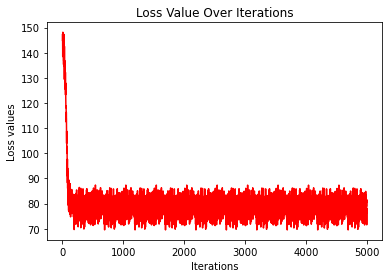

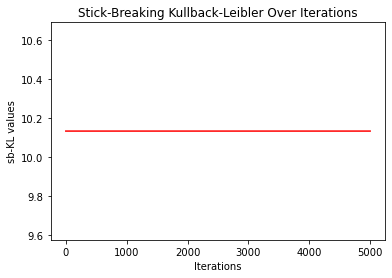

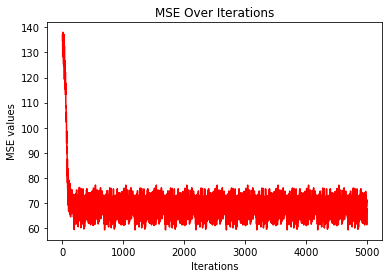


FIDS:



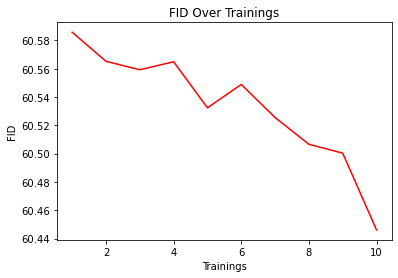

In [31]:
_SBVAE_fashionmnist, fids_sbvae_fashionmnist, losses_sbvae_fashionmnist, summaries_sbvae_fashionmnist =(
    perform_analysis(
        "SB-VAE",
        sb_base,
        fashionmnist,
        fashionmnist_activations,
        get_activations_fashionmnist
    )
)

THE MODEL FID IS:
=====================>60.446075845910855

THE MODEL LOSS IS:
=====================>76.66474914550781

THE MODEL KULLBACK-LEIBLER LOSS IS:
=====================>10.134631156921387

THE MODEL MSE LOSS IS:
=====================>66.53011322021484

SAMPLING EXAMPLE


<Figure size 432x288 with 0 Axes>

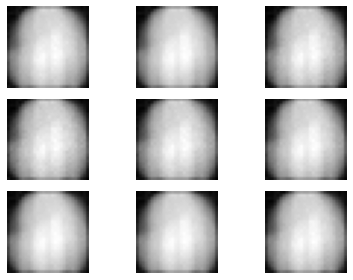

SAMPLING EXAMPLE: X100


<Figure size 432x288 with 0 Axes>

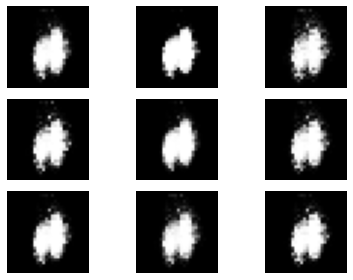

In [46]:
show_performance(fids_sbvae_fashionmnist, losses_sbvae_fashionmnist, summaries_sbvae_fashionmnist, _SBVAE_fashionmnist)